[Colab] Please upload the Excel file (must contain element/a/b/(kappa)/(exp1)/(exp2)):


Saving endmembers_22elems.xlsx to endmembers_22elems (1).xlsx
[Colab] Received: endmembers_22elems (1).xlsx → Saved as: endmembers_22elems.xlsx
[Info] Output directory: /content/mixing22_colab_upload_no_visc_guard


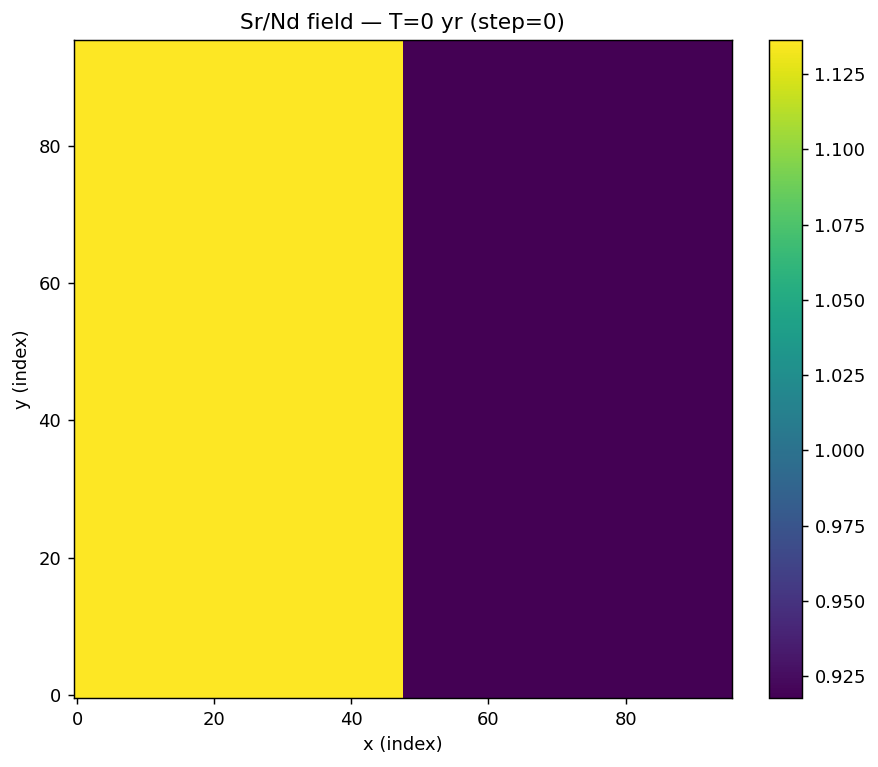

[Saved] mixing22_colab_upload_no_visc_guard/SrNd_field_t0.png


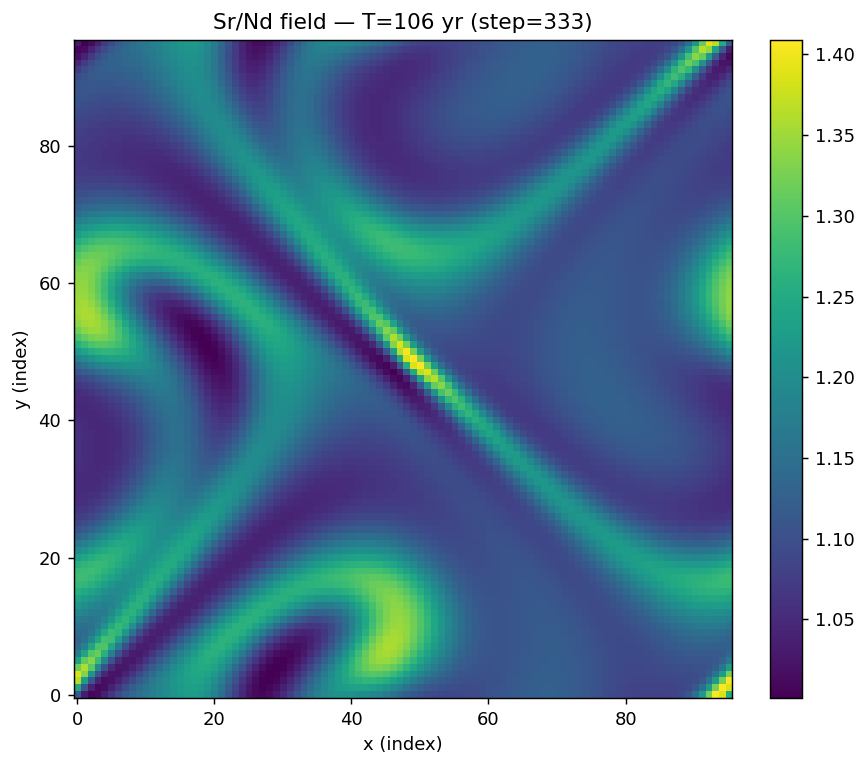

[Saved] mixing22_colab_upload_no_visc_guard/SrNd_field_t333.png


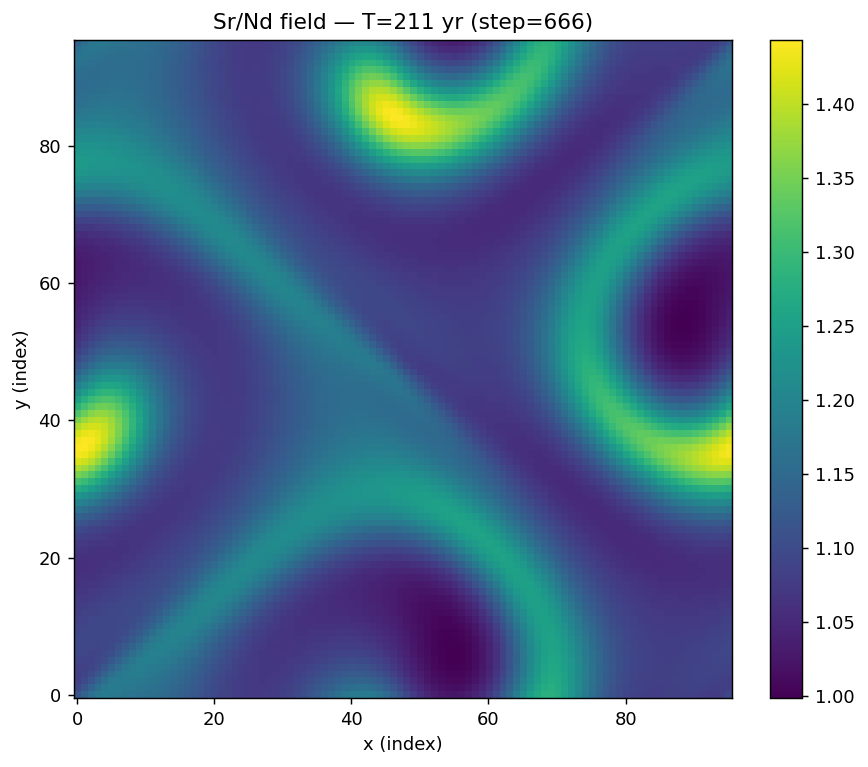

[Saved] mixing22_colab_upload_no_visc_guard/SrNd_field_t666.png


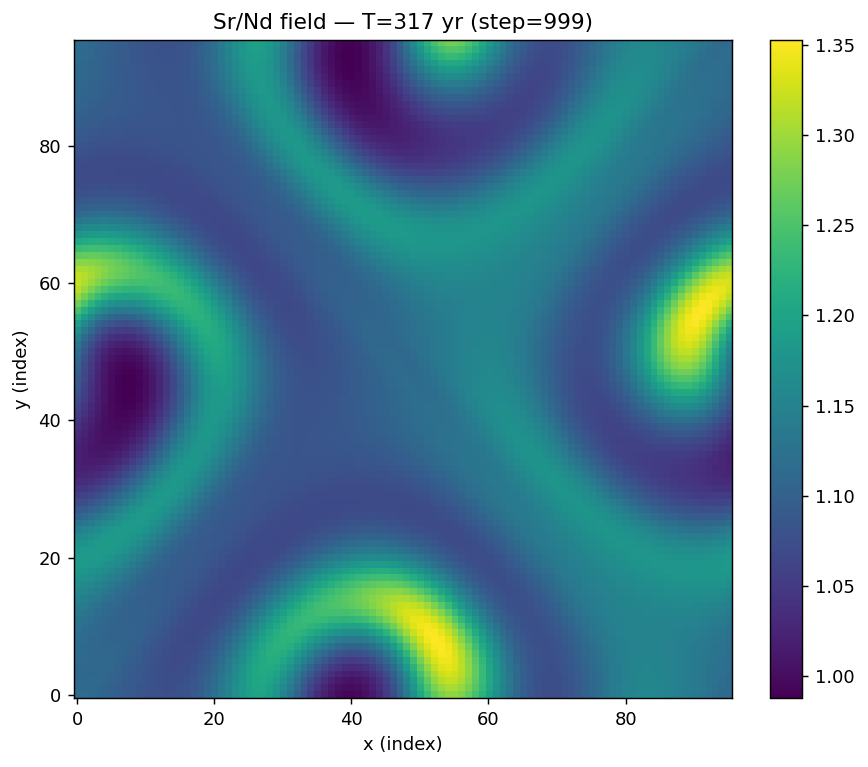

[Saved] mixing22_colab_upload_no_visc_guard/SrNd_field_t999.png


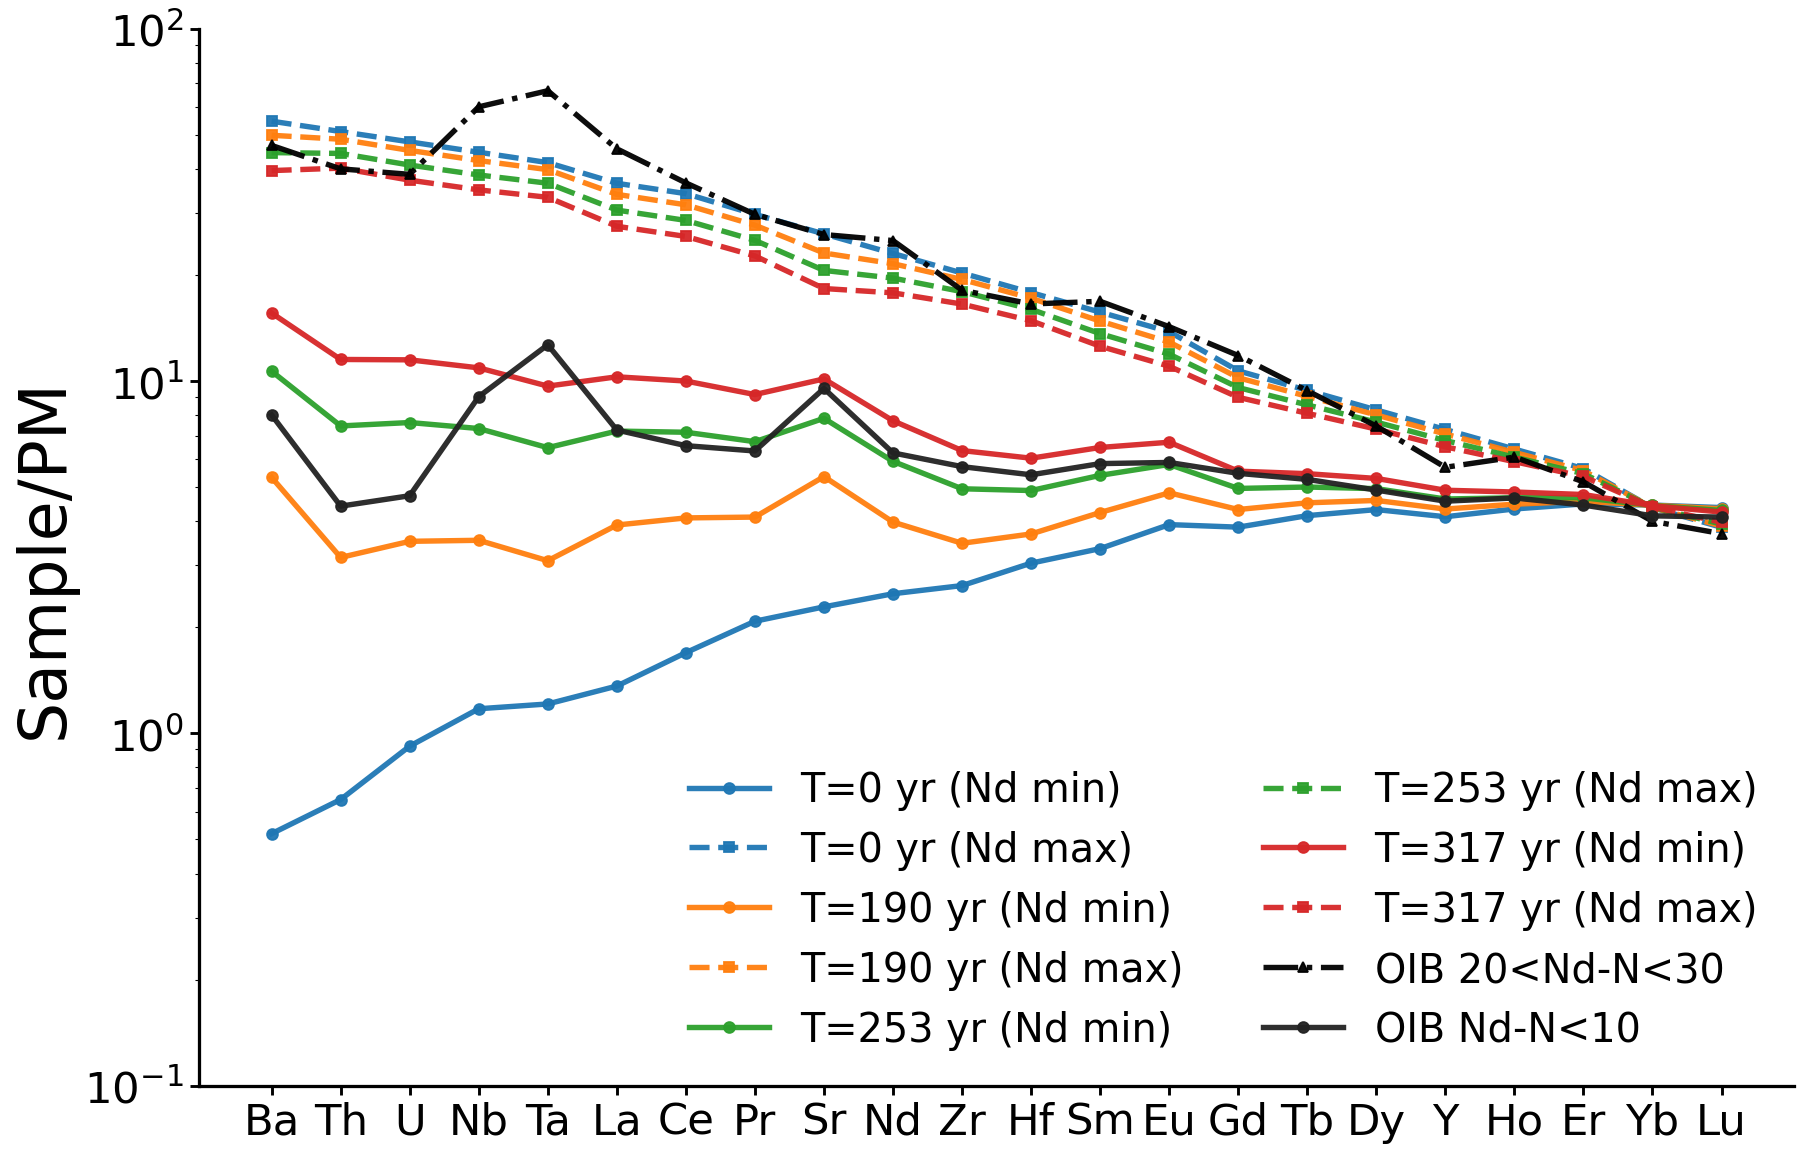

[Saved] mixing22_colab_upload_no_visc_guard/Elem22_profile_SELECTED_TIMES_log_WITH_EXP.png


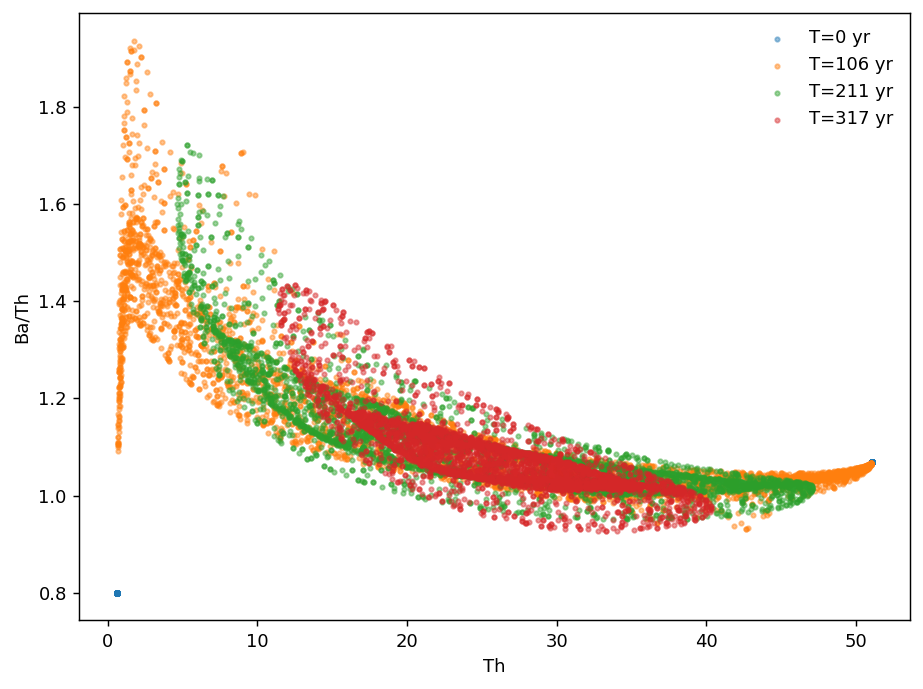

[Saved] mixing22_colab_upload_no_visc_guard/BaTh_vs_Th_DEFAULT4.png

[Done] All figures have been written to: /content/mixing22_colab_upload_no_visc_guard


In [ ]:
"""
22-element 2D advection–diffusion mixing
- Excel (recommended name: endmembers_22elems.xlsx; sheet name: endmembers_22elems)
  Required columns: element, a, b; Optional: kappa, exp1, exp2
  element example: Ba Th U Nb Ta La Ce Pr Sr Nd Zr Hf Sm Eu Gd Tb Dy Y Ho Er Yb Lu
- Outputs:
  (1) Sr/Nd fields at 4 time steps
  (2) “Combined line plot” (log-scale y-axis): using only your selected times; at each time taking the two locations of Nd min/max + overlaying exp1/exp2 if present
  (3) Ba/Th vs Th scatter plots at 4 times
"""

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from dataclasses import dataclass

# ========== popup upload window on each run ==========
try:
    from google.colab import files as _colab_files
except Exception as _e:
    raise RuntimeError("This script is intended for Google Colab. Please run in Colab to enable file upload.") from _e

print("[Colab] Please upload the Excel file (must contain element/a/b/(kappa)/(exp1)/(exp2)):")
_uploaded = _colab_files.upload()  # ← Popup on every run
if not _uploaded:
    raise FileNotFoundError("No file uploaded.")

# Use the first .xlsx file (if multiple exist, rename the one you want as EXCEL_PATH)
_excel_name = None
for _fn in _uploaded.keys():
    if str(_fn).lower().endswith(".xlsx"):
        _excel_name = _fn
        break
if _excel_name is None:
    raise ValueError("No .xlsx file detected.")

EXCEL_PATH = "endmembers_22elems.xlsx"  # unified name for consistent later loading
if _excel_name != EXCEL_PATH:
    if os.path.exists(EXCEL_PATH):
        os.remove(EXCEL_PATH)
    os.rename(_excel_name, EXCEL_PATH)
print(f"[Colab] Received: {_excel_name} → Saved as: {EXCEL_PATH}")

# ========== Basic display settings ==========
plt.rcParams['text.usetex'] = False
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 130

# ========== Configuration ==========
SHEET_NAME = "endmembers_22elems"   # must match the sheet name in Excel

# Customizable experimental curve names (for the combined line plot)
EXP1_LABEL = "OIB 20<Nd-N<30"
EXP2_LABEL = "OIB Nd-N<10"

@dataclass
class CFG:
    # Grid & time
    N: int = 96         # grid size (N×N)
    L: float = 10.0     # physical domain length (m)
    dt: float = 1.0e7   # time step (s)
    steps: int = 1000    # total steps
    # Alternating sine flow (no guard; amp = A0)
    A0: float = 4e-9  # velocity amplitude (m/s), independent of any field
    switch_period: int = 10  # switch orthogonal direction every few steps
    # Default molecular diffusivity (used when kappa not provided for an element)
    kappa_default: float = 6e-11
    # Output directory
    outdir: str = "mixing22_colab_upload_no_visc_guard"
    # Time conversion
    seconds_per_year: float = 365.25*86400.0
    time_unit: str = "yr"
    # —— Time points for combined line plot (choose either years or steps) ——
    profile_years: tuple = (0, 190, 253, 317)  # specify in “years”
    profile_steps: tuple = None                # or directly specify step numbers

C = CFG()
os.makedirs(C.outdir, exist_ok=True)

# ========== Read Excel (endmembers/diffusivity + experiment columns) ==========
def read_elements_excel_and_exp_only(path, sheet):
    df = pd.read_excel(path, sheet_name=sheet)
    df.columns = [str(c).strip().lower() for c in df.columns]
    for c in ("element", "a", "b"):
        if c not in df.columns:
            raise ValueError(f"Sheet {sheet} must contain: element, a, b")
    df["element"] = df["element"].astype(str).str.strip()
    if len(df) != 22:
        raise ValueError(f"{sheet} must have exactly 22 rows (currently {len(df)})")

    elements = df["element"].tolist()
    concA_map = dict(zip(elements, df["a"].astype(float)))
    concB_map = dict(zip(elements, df["b"].astype(float)))
    kappa_map = dict(zip(elements, df["kappa"].astype(float))) if "kappa" in df.columns else {}

    # Experimental columns (optional, tolerant to multiple name patterns)
    def pick_col(cands):
        for c in cands:
            if c in df.columns: return c
        return None
    c1 = pick_col(["exp1", "experiment1", "profile1", "data1", "exp_1"])
    c2 = pick_col(["exp2", "experiment2", "profile2", "data2", "exp_2"])
    exp1_vals = df[c1].astype(float).tolist() if c1 else None
    exp2_vals = df[c2].astype(float).tolist() if c2 else None

    lows = [e.lower() for e in elements]
    for need in ("sr", "nd", "ba", "th"):
        if need not in lows:
            raise ValueError("Missing required elements: Sr / Nd / Ba / Th")

    return elements, concA_map, concB_map, kappa_map, exp1_vals, exp2_vals

elements, concA_map, concB_map, kappa_map, exp1_vals, exp2_vals = \
    read_elements_excel_and_exp_only(EXCEL_PATH, SHEET_NAME)

# Quick case-insensitive mapping
lower_to_name = {e.lower(): e for e in elements}
SR, ND, BA, TH = lower_to_name["sr"], lower_to_name["nd"], lower_to_name["ba"], lower_to_name["th"]

# ========== Grid & initial conditions ==========
N, L, dt = C.N, C.L, C.dt
dx = L/N; dy = L/N
x = (np.arange(N)+0.5)*dx; y = (np.arange(N)+0.5)*dy
X, Y = np.meshgrid(x, y, indexing="ij")

def steps_to_years(s): return s * dt / C.seconds_per_year

def split_field(a, b, frac=0.5):
    """Initialize as two-endmember split: left half = A, right half = B"""
    F = np.zeros((N, N))
    F[X < frac*L] = a
    F[X >= frac*L] = b
    return F

# 22-element concentration fields
conc = {e: split_field(concA_map[e], concB_map[e]) for e in elements}

# ========== Numerical kernels ==========
def advect(Cf, u, v, dt_local):
    """Semi-Lagrangian advection (periodic BC; stable for large displacements)"""
    Xb = (X - u*dt_local) % L
    Yb = (Y - v*dt_local) % L
    xb = Xb/dx - 0.5; yb = Yb/dy - 0.5
    i0 = np.floor(xb).astype(int) % N; j0 = np.floor(yb).astype(int) % N
    i1 = (i0 + 1) % N;               j1 = (j0 + 1) % N
    sx = xb - np.floor(xb);          sy = yb - np.floor(yb)
    C00 = Cf[i0, j0]; C10 = Cf[i1, j0]; C01 = Cf[i0, j1]; C11 = Cf[i1, j1]
    return (1-sx)*(1-sy)*C00 + sx*(1-sy)*C10 + (1-sx)*sy*C01 + sx*sy*C11

def diffuse(Cf, kappa, dt_local):
    """Explicit diffusion (stability condition: dt <= dx^2/(4*kappa_max))"""
    Cxx = (np.roll(Cf, -1, 0) - 2*Cf + np.roll(Cf, 1, 0)) / dx**2
    Cyy = (np.roll(Cf, -1, 1) - 2*Cf + np.roll(Cf, 1, 1)) / dy**2
    return Cf + kappa*dt_local*(Cxx + Cyy)

def vel(t, amp):
    """Alternating sine flow: switches direction every switch_period steps; amp is scalar A0"""
    ph = (t // C.switch_period) % 2
    if ph == 0:
        u = amp*np.sin(2*np.pi*(Y/L)); v = np.zeros_like(u)
    else:
        u = np.zeros_like(X); v = amp*np.sin(2*np.pi*(X/L))
    return u, v

# ========== Snapshot times ==========
BASE_STEPS = tuple(np.linspace(0, C.steps-1, 4, dtype=int))  # Sr/Nd fields & Ba/Th scatter
def yrs_to_steps(yrs):
    return tuple(np.clip(np.round(np.array(yrs)*C.seconds_per_year/dt).astype(int), 0, C.steps-1))
PROFILE_STEPS = (yrs_to_steps(C.profile_years) if C.profile_years is not None
                 else (tuple(C.profile_steps) if C.profile_steps else BASE_STEPS))
ALL_SNAP_STEPS = tuple(sorted(set(BASE_STEPS) | set(PROFILE_STEPS)))

# ========== Main loop ==========
snaps = {}  # step -> {element: 2D array}
def save_snap(t): snaps[t] = {e: conc[e].copy() for e in elements}
if 0 in ALL_SNAP_STEPS: save_snap(0)

# Diffusion stability warning
kappa_max = max([kappa_map.get(e, C.kappa_default) for e in elements])
dt_stable = min(dx, dy)**2 / (4*kappa_max + 1e-30)
if dt > dt_stable:
    print(f"[Warning] dt={dt:.2g} > diffusion stability limit≈{dt_stable:.2g}; consider reducing dt or increasing N.")

for t in range(1, C.steps):
    amp = C.A0
    u, v = vel(t, amp)

    # Advection
    for k in conc:
        conc[k][:] = advect(conc[k], u, v, dt)

    # Diffusion
    for k in conc:
        conc[k][:] = diffuse(conc[k], kappa_map.get(k, C.kappa_default), dt)

    if t in ALL_SNAP_STEPS: save_snap(t)

# Final ensuring all requested snapshots exist
for s in ALL_SNAP_STEPS:
    if s not in snaps: save_snap(s)

print(f"[Info] Output directory: {os.path.abspath(C.outdir)}")

# ========== (1) Sr/Nd fields (4 times) ==========
def plot_srnd_field(s):
    S = np.divide(snaps[s][SR], snaps[s][ND],
                  out=np.full_like(snaps[s][SR], np.nan),
                  where=snaps[s][ND] > 0)
    plt.figure(figsize=(6.8, 6.0))
    im = plt.imshow(S.T, origin="lower", cmap="viridis")
    cb = plt.colorbar(im, fraction=0.046)
    cb.ax.yaxis.set_major_formatter(FormatStrFormatter('%.6f')); cb.update_ticks()
    plt.xlabel("x (index)"); plt.ylabel("y (index)")
    plt.title(f"Sr/Nd field — T={steps_to_years(s):.0f} {C.time_unit} (step={s})")
    plt.tight_layout()
    fp = os.path.join(C.outdir, f"SrNd_field_t{s}.png")
    plt.savefig(fp, dpi=160)
    plt.show()
    plt.close()
    print("[Saved]", fp)

for s in BASE_STEPS:
    plot_srnd_field(s)

# ========== (2) Combined line plot (log y-axis) ==========
def nd_extrema(snapshot):
    Nd = snapshot[ND]
    mask = np.isfinite(Nd)
    imin = np.unravel_index(np.nanargmin(np.where(mask, Nd, np.nan)), Nd.shape)
    imax = np.unravel_index(np.nanargmax(np.where(mask, Nd, np.nan)), Nd.shape)
    return imin, imax

def sample22(snapshot, ij):
    i, j = ij
    return np.array([float(snapshot[e][i, j]) for e in elements], float)

def plot_lines_selected(steps, exp1_vals=None, exp2_vals=None,
                        exp1_label="Experiment 1", exp2_label="Experiment 2",
                        figsize=(12.5, 5.2), box_aspect=None,
                        ylabel="Concentration (log scale)"):

    x = np.arange(len(elements)); eps = 1e-30
    fig, ax = plt.subplots(figsize=figsize)
    if box_aspect is not None:
        ax.set_box_aspect(box_aspect)

    colors = plt.rcParams['axes.prop_cycle'].by_key().get('color', None)

    # Simulated curves (Nd min & Nd max at each selected time)
    for idx, s in enumerate(steps):
        snap = snaps[s]
        pmin, pmax = nd_extrema(snap)
        vmin = np.clip(sample22(snap, pmin), eps, None)
        vmax = np.clip(sample22(snap, pmax), eps, None)
        col = None if colors is None else colors[idx % len(colors)]
        ax.plot(x, vmin, '-o', lw=3, alpha=0.95, color=col,
                label=f"T={steps_to_years(s):.0f} {C.time_unit} (Nd min)")
        ax.plot(x, vmax, '--s', lw=3, alpha=0.95, color=col,
                label=f"T={steps_to_years(s):.0f} {C.time_unit} (Nd max)")

    # Experimental curves (exp1: dark gray; exp2: black)
    def add_exp(vals, label, style):
        if vals is None: return
        arr = np.asarray(vals, float)
        bad = (~np.isfinite(arr)) | (arr <= 0)
        if np.any(bad): arr = np.where(bad, np.nan, arr)
        ax.plot(x, arr, **style, label=label)

    add_exp(exp1_vals, exp1_label, dict(color="black",   lw=3, marker="^", linestyle="-.", alpha=0.95))
    add_exp(exp2_vals, exp2_label, dict(color="#222222", lw=3, marker="o", linestyle="-",  alpha=0.95))

    ax.set_xticks(x)
    ax.set_xticklabels(elements, rotation=0, ha='center', fontsize=24)

    ax.set_yscale('log')
    ax.set_ylim(0.1, 100)
    ax.set_ylabel(ylabel, fontsize=36)

    ax.tick_params(axis='both', labelsize=24, width=1.6, length=5)
    ax.spines["left"].set_linewidth(1.8)
    ax.spines["bottom"].set_linewidth(1.8)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.legend(frameon=False, ncol=2, fontsize=22)

    fig.tight_layout()

    fp = os.path.join(C.outdir, "Elem22_profile_SELECTED_TIMES_log_WITH_EXP.png")
    fig.savefig(fp, dpi=170)
    plt.show()
    plt.close(fig)
    print("[Saved]", fp)

plot_lines_selected(
    PROFILE_STEPS, exp1_vals, exp2_vals,
    exp1_label=EXP1_LABEL, exp2_label=EXP2_LABEL,
    figsize=(14, 9),
    ylabel="Sample/PM"
)

# ========== (3) Ba/Th vs Th (4 times) ==========
def plot_ba_th(steps, max_points=4000):
    plt.figure(figsize=(7.2, 5.4))
    for s in steps:
        snap = snaps[s]
        Ba = snap[BA].ravel(); Th = snap[TH].ravel()
        r = np.divide(Ba, Th, out=np.full_like(Ba, np.nan), where=Th > 0)
        m = np.isfinite(Th) & np.isfinite(r)
        Xs, Ys = Th[m], r[m]
        if Xs.size > max_points:
            idx = np.random.choice(Xs.size, max_points, replace=False)
            Xs, Ys = Xs[idx], Ys[idx]
        plt.scatter(Xs, Ys, s=6, alpha=0.45, label=f"T={steps_to_years(s):.0f} {C.time_unit}")
    plt.xlabel("Th"); plt.ylabel("Ba/Th")
    plt.grid(False); plt.legend(frameon=False)
    plt.tight_layout()
    fp = os.path.join(C.outdir, "BaTh_vs_Th_DEFAULT4.png")
    plt.savefig(fp, dpi=160)
    plt.show()
    plt.close()
    print("[Saved]", fp)

plot_ba_th(BASE_STEPS)

print("\n[Done] All figures have been written to:", os.path.abspath(C.outdir))
